## Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
# Import the following libraries to get started.
import numpy as np
import os
#from scipy.misc import imread, imresize
import imageio
from PIL import Image
import datetime

We Will set the random seed so that the results don't vary drastically.

In [42]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [43]:
train_doc = np.random.permutation(open('../datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../datasets/Project_data/val.csv').readlines())

### Generator

This is one of the most important parts of the code. In the generator, we are going to pre-process the images as we have images of different dimensions (50 x 50, 70 x 70 and 120 x 120) as well as create a batch of video frames. The generator should be able to take a batch of videos as input without any error. Steps like cropping/resizing and normalization should be performed successfully.  We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [57]:
from PIL import Image
#!pip install scikit-image
from skimage.transform import resize

In [69]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = #create a list of image numbers you want to use for a particular video
    while True:
        #Shuffle the list of the folders in csv
        t = np.random.permutation(folder_list)
         #Exact batches of the batch size
        num_batches = int(len(t)/batch_size)
         #Left over batches which should be handled separately
        leftover_batches = len(t) - num_batches * batch_size
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),shape_h, shape_w,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = resize(image, (shape_h,shape_w))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 104
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 117
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 123

                #Fill the one hot encoding stuff where we maintain the label
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if leftover_batches != 0:
            for batch in range(num_batches): 
                # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((batch_size,len(img_idx),shape_h, shape_w,3)) 
                # batch_labels is the one hot representation of the output: 10 videos with 5 columns as classes
                batch_labels = np.zeros((batch_size,5)) 
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path +'/'+t[batch * batch_size + folder].split(';')[0])
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        
                        image = imageio.imread(source_path +'/'+t[batch * batch_size + folder].split(';')[0] +'/'+imgs[item]).astype(np.float32)
                        image = resize(image, (shape_h,shape_w))

                        batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 104
                        batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 117
                        batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 123
                        
                    #Fill the one hot encoding stuff where we maintain the label
                    batch_labels[folder, int(t[batch * batch_size + folder].split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



A video is represented above in the generator as (number of images, height, width, number of channels). We take this into consideration while creating the model architecture.

In [59]:
curr_dt_time = datetime.datetime.now()
train_path = '../datasets/Project_data/train'
val_path = '../datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


Source path =  ../datasets/Project_data/train ; batch size = 3


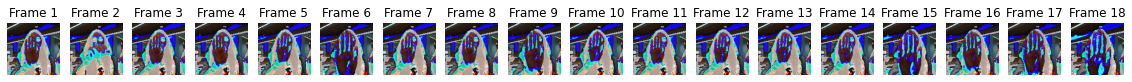

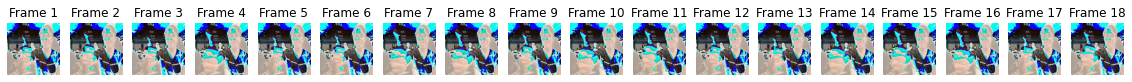

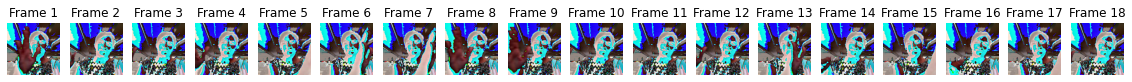

In [81]:
# testing generative
test_gen = generator(train_path, train_doc, batch_size=3)  # Set batch_size to 10
batch_data, batch_labels = next(test_gen)

# Display the first 3 images from the batch
num_frames = batch_data.shape[1]

for i in range(3):  # Displaying the first 10 images from the batch
    plt.figure(figsize=(20,10))
    for j in range(num_frames):
        plt.subplot(1, num_frames, j + 1)
        plt.imshow(batch_data[i][j].astype('uint8'))
        plt.title(f"Frame {j + 1}")
        plt.axis('off')
    plt.show()


### Model

Here we make the model using different functionalities that Keras provides. We must use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would also use `TimeDistributed` while building a Conv2D + RNN model. Also, the last layer is the softmax. We design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [68]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,  Dropout, LSTM, ConvLSTM2D
from tensorflow.keras import regularizers
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers


#write your model here
class Conv3DModel():
    
    def Model3D(self,frames_to_sample,image_height,image_width):
        
        model = Sequential()
        model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

        model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

        # model.add(Dropout(0.25))

        model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

        # model.add(Dropout(0.25))

        model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

        model.add(Flatten())

        model.add(Dropout(0.5))
        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        
        #write your optimizer TRY OUT WITH ADAM AND SGD
        '''
        Classes
        class Adadelta: Optimizer that implements the Adadelta algorithm.

        class Adagrad: Optimizer that implements the Adagrad algorithm.

        class Adam: Optimizer that implements the Adam algorithm.

        class Adamax: Optimizer that implements the Adamax algorithm.

        class Ftrl: Optimizer that implements the FTRL algorithm.

        class Nadam: Optimizer that implements the NAdam algorithm.

        class Optimizer: Base class for Keras optimizers.

        class RMSprop: Optimizer that implements the RMSprop algorithm.

        class SGD: Gradient descent (with momentum) optimizer.
        '''
        
        optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Once we have written the model, the next step is to `compile` the model. When we print the `summary` of the model, we can see the total number of parameters we have to train.

In [8]:
# Global vars
def global_vars(img_idx,shape_h,shape_w,batch_size,num_epochs):
    print("the number of images we will be feeding in the input for a video {}".format(len(img_idx)))
    return img_idx,shape_h,shape_w,batch_size,num_epochs

### Model 1

In [9]:
# Model 1: No of Epochs = 15 , batch_size = 64 ,shape = (120,120) , no of frames = 10

img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars([6,8,10,12,14,16,20,22,24,26],120,120,64,15)
conv_model1=Conv3DModel()
conv_model1=conv_model1.Model3D(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model1.summary()

the number of images we will be feeding in the input for a video 10
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 120, 120, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 10, 120, 120, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 10, 120, 120, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 60, 120, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 60, 120, 128)   221312    
                                                      

2024-05-10 17:30:30.110465: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-10 17:30:30.110542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5
/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Let us create the train_generator and the val_generator  which will be used in .fit_generator

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

#Fix the file path        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Callback to save the Keras model or model weights at some frequency.
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights.
#path to save the model file.
#"val_loss" to monitor the model's total loss in validation.
#saves when the model is considered the "best"
#the model's weights will be saved
#the minimization of the monitored quantity

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#Reduce learning rate when a metric has stopped improving.
#LR = ReduceLROnPlateau(monitor, factor, aptience, min_lr)
#monitor: quantity to be monitored.
#factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
#patience: number of epochs with no improvement after which learning rate will be reduced.
#min_lr: lower bound on the learning rate.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)

EarlyStop = EarlyStopping(monitor='val_loss', patience=6 )
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
print(steps_per_epoch)
print(validation_steps)

11
2


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
conv_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     callbacks=callbacks_list, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../datasets/Project_data/train ; batch size = 64
Epoch 1/15


2024-05-10 11:34:59.680717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2024-05-10 11:35:02.476916: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-05-10 11:35:03.395285: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-05-10 11:35:04.364064: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

ResourceExhaustedError:  OOM when allocating tensor with shape[64,128,5,60,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/max_pooling3d_1/MaxPool3D/MaxPool3DGrad
 (defined at /usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1426]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/sequential/max_pooling3d_1/MaxPool3D/MaxPool3DGrad:
In[0] sequential/activation_1/Elu (defined at /usr/local/lib/python3.8/dist-packages/keras/backend.py:4893)	
In[1] sequential/max_pooling3d_1/MaxPool3D (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)	
In[2] gradient_tape/sequential/conv3d_2/Conv3D/Conv3DBackpropInputV2:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_459/3678496989.py", line 1, in <module>
>>>     conv_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

Model 1 is giving the out of memory error with batch size 64. We try with less batch size and shapes to further improve the performance


### Model 2

In [15]:
# Model 2: No of Epochs = 20; batch_size = 20; shape = (50,50); no of frames = 6

img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars(list(range(0,30,5)),50,50,20,20)
conv_model2=Conv3DModel()
conv_model2=conv_model2.Model3D(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model2.summary()

the number of images we will be feeding in the input for a video 6
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 6, 50, 50, 64)     5248      
                                                                 
 batch_normalization_4 (Batc  (None, 6, 50, 50, 64)    256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 6, 50, 50, 64)     0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 25, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 3, 25, 50, 128)    221312    
                                                     

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print(steps_per_epoch)
print(validation_steps)

34
5


In [17]:
conv_model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.6158 - categorical_accuracy: 0.3294Source path =  ../datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 7.38701, saving model to model_init_2024-05-1011_34_29.180616/model-00001-2.61583-0.32941-7.38701-0.23000.h5
34/34 [==============================] - 36s 1s/step - loss: 2.6158 - categorical_accuracy: 0.3294 - val_loss: 7.3870 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.6183 - categorical_accuracy: 0.4809
Epoch 00002: val_loss improved from 7.38701 to 5.43365, saving model to model_init_2024-05-1011_34_29.180616/model-00002-1.61828-0.48088-5.43365-0.25000.h5
34/34 [==============================] - 35s 1s/step - loss: 1.6183 - categorical_accuracy: 0.4809 - val_loss: 5.4336 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
34/34 [====

#### Insights:
    - Number of Epochs =20; Batch size=20; Number of frames=6
    - Taking the Frames with the step size 5 and taking 6 frames with shape (50,50) giving the goog training and validation accuracy but not upto the mark.
    Lets try another model by changing the batch sixe and the number of frame

### Model 3

In [19]:
#No of Epochs = 20; batch_size = 30; shape = (50,50); no of frames = 10 
img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars(list(range(0,30,3)),50,50,30,20)
conv_model3=Conv3DModel()
conv_model3=conv_model3.Model3D(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model3.summary()

the number of images we will be feeding in the input for a video 10
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 10, 50, 50, 64)    5248      
                                                                 
 batch_normalization_12 (Bat  (None, 10, 50, 50, 64)   256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 10, 50, 50, 64)    0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 5, 25, 50, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 5, 25, 50, 128)    221312    
                                                    

In [20]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print(steps_per_epoch)
print(validation_steps)

23
4


In [21]:
conv_model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 3.1508 - categorical_accuracy: 0.3174Source path =  ../datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss did not improve from 0.63176
23/23 [==============================] - 89s 4s/step - loss: 3.1508 - categorical_accuracy: 0.3174 - val_loss: 8.8831 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.9774 - categorical_accuracy: 0.4275
Epoch 00002: val_loss did not improve from 0.63176
23/23 [==============================] - 76s 3s/step - loss: 1.9774 - categorical_accuracy: 0.4275 - val_loss: 6.0200 - val_categorical_accuracy: 0.2417 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.5124 - categorical_accuracy: 0.5029
Epoch 00003: val_loss did not improve from 0.63176
23/23 [==============================] - 60s 3s/step - loss: 1.5124 - c

#### Insights:
    Model 3: Number of Epochs =20; Batch size=30; shape = (50,50); Number of frames=10
    Keeping the same shape and increasing the number of frames we have observed that training and  Validation Accuracy decreased.
    
    

### Model 4

In [22]:
# No of Epochs = 25 , batch_size = 50 ,shape = (100,100) , no of frames = 10
img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars(list(range(5,28,2)),100,100,50,25)
conv_model4=Conv3DModel()
conv_model4=conv_model4.Model3D(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model4.summary()

the number of images we will be feeding in the input for a video 12
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 12, 100, 100, 64)  5248      
                                                                 
 batch_normalization_16 (Bat  (None, 12, 100, 100, 64)  256      
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 12, 100, 100, 64)  0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 6, 50, 100, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 6, 50, 100, 128)   221312    
                                                    

In [23]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print(steps_per_epoch)
print(validation_steps)

14
2


In [24]:
conv_model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     callbacks=callbacks_list, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../datasets/Project_data/train ; batch size = 50
Epoch 1/25
14/14 [==============================] - ETA: 0s - loss: 3.8566 - categorical_accuracy: 0.3214Source path =  ../datasets/Project_data/val ; batch size = 50

Epoch 00001: val_loss did not improve from 0.63176
14/14 [==============================] - 94s 7s/step - loss: 3.8566 - categorical_accuracy: 0.3214 - val_loss: 10.5104 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 1.7445 - categorical_accuracy: 0.4957
Epoch 00002: val_loss did not improve from 0.63176
14/14 [==============================] - 70s 5s/step - loss: 1.7445 - categorical_accuracy: 0.4957 - val_loss: 8.8562 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 1.3164 - categorical_accuracy: 0.5614
Epoch 00003: val_loss did not improve from 0.63176
14/14 [==============================] - 63s 5s/step - loss: 1.3164 - 

#### Insights:
Model 4: This model seems to be overfitting. Increasing the image size decreases the validation accuracy.

### Model 5

In [25]:
#No of Epochs = 25 , batch_size = 50 ,shape = (70,70) , no of frames = 18 
img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars([0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29],70,70,50,34)
conv_model5=Conv3DModel()
conv_model5=conv_model5.Model3D(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model5.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

the number of images we will be feeding in the input for a video 18
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 18, 70, 70, 64)    5248      
                                                                 
 batch_normalization_20 (Bat  (None, 18, 70, 70, 64)   256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 18, 70, 70, 64)    0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 9, 35, 70, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 9, 35, 70, 128)    221312    
                                                    

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

In [27]:
print(steps_per_epoch)
print(validation_steps)

14
2


In [28]:
conv_model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../datasets/Project_data/train ; batch size = 50
Epoch 1/34
14/14 [==============================] - ETA: 0s - loss: 3.5842 - categorical_accuracy: 0.3586Source path =  ../datasets/Project_data/val ; batch size = 50

Epoch 00001: val_loss did not improve from 0.45033
14/14 [==============================] - 144s 11s/step - loss: 3.5842 - categorical_accuracy: 0.3586 - val_loss: 14.8659 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/34
14/14 [==============================] - ETA: 0s - loss: 1.5313 - categorical_accuracy: 0.5357
Epoch 00002: val_loss did not improve from 0.45033
14/14 [==============================] - 127s 10s/step - loss: 1.5313 - categorical_accuracy: 0.5357 - val_loss: 11.6332 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/34
14/14 [==============================] - ETA: 0s - loss: 1.2719 - categorical_accuracy: 0.5657
Epoch 00003: val_loss did not improve from 0.45033
14/14 [==============================] - 107s 8s/step - loss: 1.2

#### Insights:
Model 5 is clearly an overfit model can see that increasing in number of frames and epochs causing the noise to be learned also from all the frames

#### Overall Insights for Model 1 to 5:
    Based on our experiment the final model will be model 2 - Less no of frames and reducing image size to 50,50 giving good results
    Model 2: No of Epochs = 20 , batch_size = 20 ,shape = (50,50) , no of frames = 6

### Model 6

-  Taking image_height and image_width as 70,70 , batch size 50 and no of epochs 25
-  Switching Model architecture to Conv2D+LSTM
-  Conv2D_18, 70, 70, 16
-  LSTM_512
-  Dense_512_5

In [29]:
from keras.layers.convolutional import  Conv2D, MaxPooling2D
from keras.layers import TimeDistributed,LSTM ,ConvLSTM2D
model = Sequential([
    TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=(len(img_idx),shape_h,shape_w,3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Flatten()),
    LSTM(512),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

In [30]:
optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [31]:
model.summary()

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 70, 70, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 70, 70, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 35, 35, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 35, 35, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 35, 35, 32)  

In [32]:
train_generator = generator(train_path, train_doc, 20)
val_generator = generator(val_path, val_doc, 20)

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [34]:
print(steps_per_epoch)
print(validation_steps)

14
2


In [35]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../datasets/Project_data/train ; batch size = 20
Epoch 1/34
14/14 [==============================] - ETA: 0s - loss: 1.6890 - categorical_accuracy: 0.1786Source path =  ../datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss did not improve from 0.45033
14/14 [==============================] - 71s 5s/step - loss: 1.6890 - categorical_accuracy: 0.1786 - val_loss: 1.6202 - val_categorical_accuracy: 0.2250 - lr: 0.0010
Epoch 2/34
14/14 [==============================] - ETA: 0s - loss: 1.5403 - categorical_accuracy: 0.3071
Epoch 00002: val_loss did not improve from 0.45033
14/14 [==============================] - 71s 5s/step - loss: 1.5403 - categorical_accuracy: 0.3071 - val_loss: 1.5185 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/34
14/14 [==============================] - ETA: 0s - loss: 1.4363 - categorical_accuracy: 0.4214
Epoch 00003: val_loss did not improve from 0.45033
14/14 [==============================] - 68s 5s/step - loss: 1.4363 - c

#### Insights:
  Model-6 is clearly overfitting.
  We will change the number of frames, image size and check

### Model 7

No of Epochs = 20 , number of batches=20 ,shape = (50,50), number of frames=10
img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars(list(range(0,30,3)),50,50,20,20)

The number of images we will be feeding in the input for a video 10

In [14]:
#Switching Model architecture to Conv2D+LSTM

from keras.layers.convolutional import  Conv2D, MaxPooling2D
from keras.layers import TimeDistributed,LSTM ,ConvLSTM2D
model = Sequential([
    TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=(len(img_idx),shape_h,shape_w,3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Flatten()),
    LSTM(512),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

In [15]:
optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [16]:
model.summary()

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 60, 60, 32)  

In [17]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
print(steps_per_epoch)
print(validation_steps)

11
2


In [20]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../datasets/Project_data/train ; batch size = 64
Epoch 1/15


2024-05-10 17:32:34.468026: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.6411 - categorical_accuracy: 0.2315Source path =  ../datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.63607, saving model to model_init_2024-05-1017_30_06.394783/model-00001-1.64115-0.23153-1.63607-0.21875.h5
11/11 [==============================] - 99s 9s/step - loss: 1.6411 - categorical_accuracy: 0.2315 - val_loss: 1.6361 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.4812 - categorical_accuracy: 0.3480
Epoch 00002: val_loss improved from 1.63607 to 1.61742, saving model to model_init_2024-05-1017_30_06.394783/model-00002-1.48117-0.34801-1.61742-0.21875.h5
11/11 [==============================] - 58s 6s/step - loss: 1.4812 - categorical_accuracy: 0.3480 - val_loss: 1.6174 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.3388 - categorical_accuracy

##### Insights:
    Model 7 is also clearly overfitting

### Model 8

CONV2D + GRU Changed the no of layers , no of frames are 18 , image_height and image_witdth = (50,50) , batch_size 20 , no of epochs = 20

In [22]:
img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars([0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29],50,50,20,20)

the number of images we will be feeding in the input for a video 18


In [23]:
from keras.layers.convolutional import  Conv2D, MaxPooling2D
from keras.layers import TimeDistributed,LSTM ,ConvLSTM2D
model = Sequential()    
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(len(img_idx),shape_h,shape_w,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))


model.add(GRU(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

In [24]:
optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 50, 50, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 50, 50, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 25, 25, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 25, 25, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 25, 25, 32)  

In [26]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [27]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [28]:
print(steps_per_epoch)
print(validation_steps)

34
5


In [29]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6938 - categorical_accuracy: 0.2441Source path =  ../datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss did not improve from 1.27986
34/34 [==============================] - 153s 5s/step - loss: 1.6938 - categorical_accuracy: 0.2441 - val_loss: 1.5887 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4464 - categorical_accuracy: 0.3647
Epoch 00002: val_loss did not improve from 1.27986
34/34 [==============================] - 113s 3s/step - loss: 1.4464 - categorical_accuracy: 0.3647 - val_loss: 1.5801 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3204 - categorical_accuracy: 0.4559
Epoch 00003: val_loss did not improve from 1.27986
34/34 [==============================] - 106s 3s/step - loss: 1.3204 

#### Insights:
    Model 8 has increases both the training and validation accuracy but  is also  overfit the model

### Model 9

In [83]:
img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars([0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29],120,120,5,15)

the number of images we will be feeding in the input for a video 18


In [84]:
from keras.layers.convolutional import  Conv2D, MaxPooling2D
from keras.layers import TimeDistributed,LSTM ,ConvLSTM2D
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()  
model.add(TimeDistributed(mobilenet_transfer,input_shape=(len(img_idx),shape_h,shape_w,3)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

In [85]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [86]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 128)              

In [87]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [88]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [89]:
print(steps_per_epoch)
print(validation_steps)

133
20


In [90]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../datasets/Project_data/train ; batch size = 5
Epoch 1/15
133/133 [==============================] - ETA: 0s - loss: 1.2756 - categorical_accuracy: 0.4737Source path =  ../datasets/Project_data/val ; batch size = 5

Epoch 00001: val_loss did not improve from 0.12269
133/133 [==============================] - 92s 668ms/step - loss: 1.2756 - categorical_accuracy: 0.4737 - val_loss: 1.0199 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/15
133/133 [==============================] - ETA: 0s - loss: 0.7471 - categorical_accuracy: 0.7218
Epoch 00002: val_loss did not improve from 0.12269
133/133 [==============================] - 87s 659ms/step - loss: 0.7471 - categorical_accuracy: 0.7218 - val_loss: 0.8427 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/15
133/133 [==============================] - ETA: 0s - loss: 0.6640 - categorical_accuracy: 0.7699
Epoch 00003: val_loss did not improve from 0.12269
133/133 [==============================] - 87s 660ms/step

#### Insight
This is so far the best model that we got with better accuracy

#### Conclusion

### Model Statistics

#### Conv3D

- Model 1 : No of Epochs = 15 , batch_size = 64 ,shape = (120,120) , no of frames = 10
- -  Model 1 is giving the out of memory error with batch size 64. We try with less batch size and shapes to further improve the performance and accuracy


- Model 2 : No of Epochs = 20 , batch_size = 20 ,shape = (50,50) , no of frames = 6

- -  Training Accuracy : 88.68% , Validation Accuracy : 77.00% , 
- -  Model Analysis : Training and validation Accuracy are good but not upto the mark.



- Model 3 : No of Epochs = 20 , batch_size = 30 ,shape = (50,50) , no of frames = 10

- -  Training Accuracy : 82.75% , Validation Accuracy : 70.83% 
- -  Model Analysis : Keeping the same shape and increasing the number of frames we have observed that training and  validation accuracy decreased  as compared to Model-2



- Model 4 : No of Epochs = 25 , batch_size = 50 ,shape = (100,100) , no of frames = 10

- -  Training Accuracy : 91.29% , Validation Accuracy : 78% 
- -  Model Analysis : Increasing the image size increases the training accuracy but decreses the validation accuracy. This model seems to be overfitting.



- Model 5 : No of Epochs = 25 , Batch_size = 50 , shape = (70,70) , no of frames = 18 

- -  Training Accuracy : 93.29% , Validation Accuracy : 74% 
- -  Model Analysis : This model is clearly an overfit model we can see that increasing in number of frames and epochs causing the noise to be learned also from all the frames




#### CNN + RNN : CNN2D LSTM Model - TimeDistributed

- Model 6 : No of Epochs = 25 , Batch_size = 50 , shape = (70,70) , no of frames = 18 

- - Training Accuracy : 75% , Validation Accuracy : 50% 
- - Model Analysis : This model is clearly Overfitting


- Model 7 : No of epochs = 20 , batch_size = 20 , shape  (50,50) , no of frames  = 10 

- -  Training Accuracy : 86.08% , Validation Accuracy : 54.69% 
- - Model Analysis : This model is clearly overfitting



#### CONV2D + GRU

- Model 8 : No of epochs = 20 , batch_size = 20 , shape  (50,50) , no of frames  = 18

- -  Training Accuracy : 90.15%, Validation Accuracy : 61% 
- -  Model Analysis : This model is overfitting

Transfer Learning Using MobileNet

-  Model 9 : No of epochs = 15 , batch_size = 5 , shape  (120,120) , no of frames  = 18

- - Training Accuracy : 99.25% , Validation Accuracy : 94% 
- - Model Analysis : This is so far the best model that we got with better accuracy